In [1]:
import os
import cv2
import sys
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model

Using TensorFlow backend.


In [2]:
PROGRAM_PATH = os.path.abspath("..")
if PROGRAM_PATH not in sys.path:
    sys.path.append(PROGRAM_PATH)

In [3]:
from Helpers.GeneralHelpers import *
from Helpers.RHDHelpers import *
from DataHandling.PreProcessing import *
from Model.PoolingAndFire import create_loss_function

In [4]:
MODEL_FILE = os.path.expanduser("~/results/SVPGestureRec/all_points_overfit_1.h5py")
#MODEL_FILE = os.path.expanduser("~/results/SqueezeDet/all_points_complete_run_09.h5py")
#MODEL_FILE = os.path.expanduser("~/results/SVPGestureRec/all_points_overfit_32.h5py")
RHD_ANNOTATIONS_FILE = os.path.expanduser("~/datasets/RHD/RHD_published_v2/training/anno_training.pickle")
VALIDATION_DIR = os.path.expanduser("~/datasets/RHD/processed/validation")
TRAIN_DIR = os.path.expanduser("~/datasets/RHD/processed/train")
VALIDATION_ANNOTATIONS = os.path.expanduser("~/datasets/RHD/processed/validation/annotations/")
TRAIN_ANNOTATIONS = os.path.expanduser("~/datasets/RHD/processed/train/annotations/")

In [5]:
create_rhd_annotations(RHD_ANNOTATIONS_FILE,
                       VALIDATION_ANNOTATIONS,
                       VALIDATION_DIR,
                       fingers='ALL',
                       hands_to_annotate='BOTH',
                       annotate_non_visible=False,
                       force_new_files=True)

100%|██████████| 413/413 [00:00<00:00, 4465.82it/s]

Creating annotations in directory: /home/clh/datasets/RHD/processed/validation
Using annotation file: /home/clh/datasets/RHD/RHD_published_v2/training/anno_training.pickle
And outputting to: /home/clh/datasets/RHD/processed/validation/annotations/


In [6]:
BATCHSIZE = 16
EPSILON = 1e-16

LABEL_WEIGHT = 1.0
OFFSET_LOSS_WEIGHT = 1.0
OFFSET_SCALE = int(320 / 20) / 2

NUM_CLASSES = 42
NUM_HANDS = 2

l = create_loss_function(20,
                         20,
                         LABEL_WEIGHT,
                         OFFSET_LOSS_WEIGHT,
                         NUM_CLASSES,
                         EPSILON,
                         BATCHSIZE)

In [7]:
model = load_model(MODEL_FILE, custom_objects={'loss_function': l})

In [8]:
#model.summary()

In [9]:
samples_dir = TRAIN_DIR
annotations_dir = TRAIN_ANNOTATIONS
NUM_SAMPLES_TO_CHECK = BATCHSIZE

In [10]:
#samples_to_check = []
#for fi in os.listdir(samples_dir):
#    if fi.endswith('png'):
#        samples_to_check.append(int(fi.split('.')[0]))
#        if len(samples_to_check) >= NUM_SAMPLES_TO_CHECK:
#            break

#print(samples_to_check)

In [11]:
samples = np.array(sorted(get_all_samples(samples_dir, sample_type='png')))
ind = np.random.randint(0, len(samples), size=NUM_SAMPLES_TO_CHECK)
ind = range(10)
ind = [0]
samples_to_check = samples[ind]
print(samples_to_check)

[0]


In [12]:
labels, images = load_data_with_anchors(samples_to_check,
                                        samples_dir,
                                        annotations_dir,
                                        320, 320,
                                        20, 20,
                                        OFFSET_SCALE,
                                        'png',
                                        num_classes=NUM_CLASSES,
                                        greyscale=True)

images_show = np.zeros((len(images), 320, 320, 3), dtype=np.uint8)
#for c, im in enumerate(images):
#    #images_show[c] = cv2.cvtColor((im * 255.0).astype(np.uint8), cv2.COLOR_BGR2RGB)
#    images_show[c][:, :, 0] = im.reshape(320, 320) * 255.0
#    images_show[c][:, :, 1] = im.reshape(320, 320) * 255.0
#    images_show[c][:, :, 2] = im.reshape(320, 320) * 255.0

for c, s in enumerate(samples_to_check):
    images_show[c] = load_image(samples_dir, s)

print(np.max(images[0]))

3.2343757152557373


In [13]:
for l in labels:
    print(l.shape)
    for i in range(NUM_CLASSES):
        offset_xs = l[:, :, NUM_CLASSES+i*2]
        offset_ys = l[:, :, NUM_CLASSES+1+i*2]
        
        print(f"Offset max x: {np.max(offset_xs)}")
        print(f"Offset max y: {np.max(offset_ys)}")
        print("")

(20, 20, 126)
Offset max x: 0.08749961853027344
Offset max y: 0.0625

Offset max x: 0.0
Offset max y: 0.0

Offset max x: 0.6125001907348633
Offset max y: 0.0

Offset max x: 0.125
Offset max y: 0.7875003814697266

Offset max x: 0.0
Offset max y: 0.3250007629394531

Offset max x: 0.0
Offset max y: 0.0

Offset max x: 0.0
Offset max y: 0.6875

Offset max x: 0.0
Offset max y: 0.1875

Offset max x: 0.8874998092651367
Offset max y: 0.0

Offset max x: 0.35000038146972656
Offset max y: 0.0

Offset max x: 0.23750019073486328
Offset max y: 0.0

Offset max x: 0.16250038146972656
Offset max y: 0.46249961853027344

Offset max x: 0.3000001907348633
Offset max y: 0.0

Offset max x: 0.0
Offset max y: 0.16250038146972656

Offset max x: 0.0
Offset max y: 0.0

Offset max x: 0.0
Offset max y: 0.7000007629394531

Offset max x: 0.0
Offset max y: 0.03750038146972656

Offset max x: 0.0
Offset max y: 0.08749961853027344

Offset max x: 0.0
Offset max y: 0.0

Offset max x: 0.0
Offset max y: 0.0

Offset max x: 0.0

In [14]:
right_hand = []
left_hand = []

with open(RHD_ANNOTATIONS_FILE, 'rb') as f:
    annotations = pickle.load(f)
    
for s in samples_to_check:
    right_hand.append(get_right_hand(s, annotations))
    left_hand.append(get_left_hand(s, annotations))

In [15]:
res = np.zeros(labels.shape)
process_times = []
for c, im in enumerate(images):
    before = time.time()
    #res.append(model.predict(im.reshape(1, 320, 320, 1)))
    res[c] = model.predict(im.reshape(1, 320, 320, 1))
    process_times.append(time.time() - before)
    
process_times = np.array(process_times)
print(f"Average processing time: {np.mean(process_times)}")
print(f"Max processing time: {np.max(process_times)}")
print(f"Min processing time: {np.min(process_times)}")
print(f"Average processing time excepting first: {np.mean(process_times[1:])}")

Average processing time: 2.0171098709106445
Max processing time: 2.0171098709106445
Min processing time: 2.0171098709106445
Average processing time excepting first: nan


/home/clh/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/clh/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [16]:
for c, l in enumerate(labels):
    for i in range(NUM_CLASSES):
        finger_index = i
        if finger_index >= 21:
            finger_index -= 21
        
        single_label = np.zeros((20, 20, 3))
        single_label[:, :, 0] = labels[c, :, :, i]
        single_label[:, :, 1] = labels[c, :, :, NUM_CLASSES+i*2]
        single_label[:, :, 2] = labels[c, :, :, NUM_CLASSES+1+i*2]
        
        anchors = get_anchors(320, 320, 20, 20)

        label_points = get_all_points_from_prediction(single_label,
                                                      anchors,
                                                      threshold=1.0,
                                                      offset_weight=OFFSET_SCALE)
        
        x_points = np.zeros(len(label_points))
        y_points = np.zeros(len(label_points))
        for counter, p in enumerate(label_points):
            #x = p[0] + p[2]
            #y = p[1] + p[3]
            x_points[counter] = p[0] + p[2]
            y_points[counter] = p[1] + p[2]
        
        if len(label_points) > 0:
            x = np.mean(x_points)
            y = np.mean(y_points)

            print(f"{FINGER_MAP_INV[finger_index]}: ({x:.2f}, {y:.2f}), anchor point: ({p[0]:.2f}, {p[1]:.2f}), offset: ({p[2]:.2f}, {p[3]:.2f}), number: {len(label_points)}")

            cv2.circle(images_show[c], (int(x), int(y)), 1, (0, 255, 0), thickness=2)

Wrist: (106.70, 213.70), anchor point: (106.00, 213.00), offset: (0.70, 0.50), number: 1
Thumb1: (129.20, 220.20), anchor point: (137.00, 228.00), offset: (-7.80, -0.40), number: 1
Thumb2: (125.90, 232.90), anchor point: (121.00, 228.00), offset: (4.90, -3.00), number: 1
Thumb3: (122.00, 214.00), anchor point: (121.00, 213.00), offset: (1.00, 6.30), number: 1
Thumb4: (113.90, 205.90), anchor point: (121.00, 213.00), offset: (-7.10, 2.60), number: 1
Index1: (117.20, 239.20), anchor point: (121.00, 243.00), offset: (-3.80, -5.70), number: 1
Index2: (115.50, 222.50), anchor point: (121.00, 228.00), offset: (-5.50, 5.50), number: 1
Index3: (114.30, 221.30), anchor point: (121.00, 228.00), offset: (-6.70, 1.50), number: 1
Index4: (113.10, 235.10), anchor point: (106.00, 228.00), offset: (7.10, -3.40), number: 1
Middle1: (108.80, 245.80), anchor point: (106.00, 243.00), offset: (2.80, -1.20), number: 1
Middle2: (107.90, 244.90), anchor point: (106.00, 243.00), offset: (1.90, -5.90), number: 

In [17]:
arr = np.array([0, 1, 2, 3])
np.clip(arr, 0, 1)

array([0, 1, 1, 1])

In [18]:
THRESHOLD = 0.8

for c, r in enumerate(res):
    #print(r.shape)
    #pred = r.reshape(20, 20, 3)
    
    for i in range(NUM_CLASSES):
        
        finger_index = i
        if finger_index >= 21:
            finger_index -= 21
        
        pred = np.zeros((20, 20, 3))
        
        pred[:, :, 0] = res[c, :, :, i]
        pred[:, :, 1] = res[c, :, :, NUM_CLASSES+i*2]
        pred[:, :, 2] = res[c, :, :, NUM_CLASSES+1+i*2]
        
        #print(np.max(pred[:, :, 0]))
        
        anchors = get_anchors(320, 320, 20, 20)
        max_conf = np.max(pred[:,:,0])
        max_val = 0.8
        pred_point = get_all_points_from_prediction(pred,
                                                    anchors,
                                                    threshold=THRESHOLD,
                                                    offset_weight=OFFSET_SCALE,
                                                    is_label=False)
        
        # Find a way to handle outliers
        if len(pred_point) > 0:
            x_points = np.zeros(len(pred_point))
            y_points = np.zeros(len(pred_point))
            for counter, p in enumerate(pred_point):
                #x = p[0] + p[2]
                #y = p[1] + p[3]
                x_points[counter] = p[0] + p[2]
                y_points[counter] = p[1] + p[2]

            x = np.mean(x_points)
            y = np.mean(y_points)

            print(f"{FINGER_MAP_INV[finger_index]}  Predicted point: ({x}, {y}), max confidence: {max_conf}, num: {len(pred_point)}")

            cv2.circle(images_show[c], (int(x), int(y)), 1, (255, 0, 0), thickness=1)

Wrist  Predicted point: (106.8887882232666, 213.8887882232666), max confidence: 0.9998418092727661, num: 1
Thumb1  Predicted point: (129.20541934669018, 220.20541934669018), max confidence: 0.9996812343597412, num: 1
Thumb2  Predicted point: (125.86880683898926, 232.86880683898926), max confidence: 0.999855637550354, num: 1
Thumb3  Predicted point: (122.03968906402588, 214.03968906402588), max confidence: 0.9998099207878113, num: 1
Thumb4  Predicted point: (113.93838310241699, 205.938383102417), max confidence: 0.9998403787612915, num: 1
Index1  Predicted point: (117.20439672470093, 239.20439672470093), max confidence: 0.9997674822807312, num: 1
Index2  Predicted point: (115.45876216888428, 222.45876216888428), max confidence: 0.9998379945755005, num: 1
Index3  Predicted point: (114.26732587814331, 221.2673258781433), max confidence: 0.9998321533203125, num: 1
Index4  Predicted point: (113.06086826324463, 235.06086826324463), max confidence: 0.9998656511306763, num: 1
Middle1  Predicte

In [19]:
def confidence_score(label, prediction, num_classes):
    """
    How often does the model tag the correct anchor.
    """
    error = 0
    for i in range(num_classes):
        l = label[:, :, i]
        p = prediction[:, :, i]
        
        label_x, label_y = np.where(l==1.0)
        try:
            label_point = np.array([label_x[0], label_y[0]])
            print(f"label_point: {label_point}")
        except:
            #print("Error")
            continue

        prediction_x, prediction_y = np.where(p==np.max(p))
        prediction_point = np.array([prediction_x[0], prediction_y[0]])
        
        print(f"prediction_point: {prediction_point}")
        
        label_error = np.linalg.norm(label_point - prediction_point)
        error += label_error
        print(label_error)
        
        print("")
    
    return error

#print(res.shape)
confidence_score(labels[0], res[0], 42)

label_point: [ 6 13]
prediction_point: [ 6 13]
0.0

label_point: [ 8 14]
prediction_point: [ 8 14]
0.0

label_point: [ 7 14]
prediction_point: [ 7 14]
0.0

label_point: [ 7 13]
prediction_point: [ 7 13]
0.0

label_point: [ 7 13]
prediction_point: [ 7 13]
0.0

label_point: [ 7 15]
prediction_point: [ 7 15]
0.0

label_point: [ 7 14]
prediction_point: [ 7 14]
0.0

label_point: [ 7 14]
prediction_point: [ 7 14]
0.0

label_point: [ 6 14]
prediction_point: [ 6 14]
0.0

label_point: [ 6 15]
prediction_point: [ 6 15]
0.0

label_point: [ 6 15]
prediction_point: [ 6 15]
0.0

label_point: [ 6 14]
prediction_point: [ 6 14]
0.0

label_point: [ 6 14]
prediction_point: [ 6 14]
0.0

label_point: [ 6 15]
prediction_point: [ 6 15]
0.0

label_point: [ 6 15]
prediction_point: [ 6 15]
0.0

label_point: [ 6 14]
prediction_point: [ 6 14]
0.0

label_point: [ 6 14]
prediction_point: [ 6 14]
0.0

label_point: [ 6 15]
prediction_point: [ 6 15]
0.0

label_point: [ 6 15]
prediction_point: [ 6 15]
0.0

label_point:

0.0

In [20]:
def accuracy():
    pass

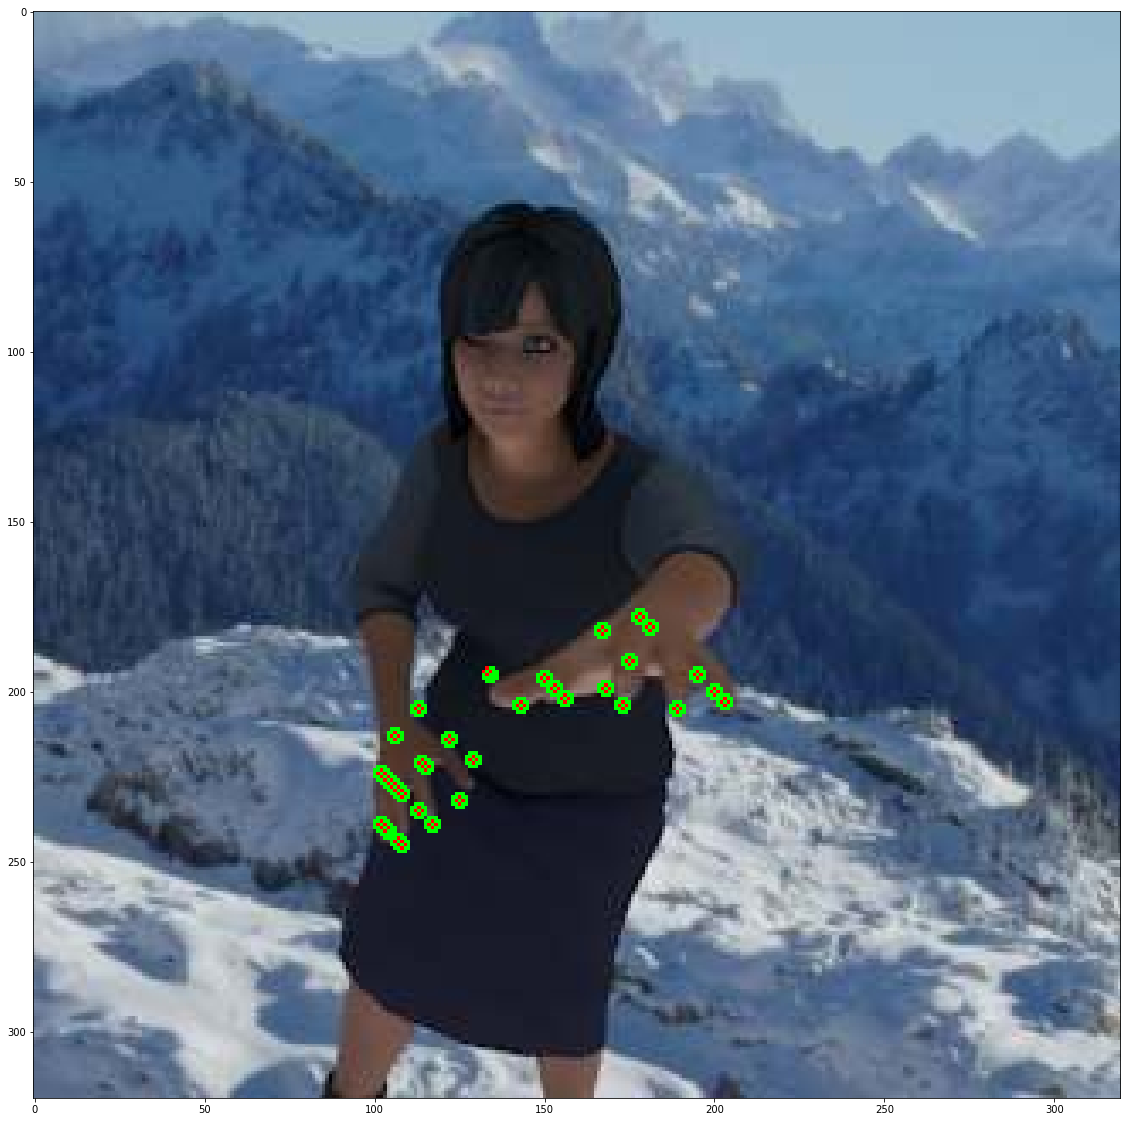

In [21]:
#f, subs = plt.subplots(len(images_show), 1, figsize=(15, 8*len(samples_to_check)))
#for c, im in enumerate(images_show):
#    subs[c].imshow(im)
    #subs[c].set_title(f"Confidence: {np.max(res[c][:,:,:,0])}")
#    subs[c].set_title(f"{samples_to_check[c]}")

f = plt.figure(figsize=(20, 20))
plt.imshow(images_show[0], cmap='gray')